In [1]:
%load_ext autoreload
%autoreload 2

In [42]:
import os
import sys
import pandas as pd
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict

In [3]:
from mixture_model_base import MixtureModelBase
from mixture_model import MixtureModel
from mixture_model_1S import MixtureModel1S
from order_stat_mixture_model import OrderStatMixtureModel
from order_stat_mixture_model_v2 import OrderStatMixtureModelV2
from xlms import XLMS_Dataset
from myutils import *


cuda


In [4]:
def collect_models_for_initskew(initskew_dir):
    p = f'{initskew_dir}/models.pickle'
    if not os.path.exists(p):
        return
    models = pickle.load(open(p, 'rb'))
    # models = pd.DataFrame(models)
    # models = NamedTensor(models.values, names=['randi', 'attr'])
    # print(models.shape)
    # print(
    return models

In [5]:
def collect_models_for_dataset(dataset_dir):
    models = []
    for initskew in os.listdir(dataset_dir):
        d = f'{dataset_dir}/{initskew}'
        if not os.path.isdir(d):
            continue
        x = collect_models_for_initskew(d)
        if x is None:
            continue
        models.append(x)
    return np.array(models)

In [101]:
def collect_models_for_strategy(config, strategy, nsamples=2):
    d = f'../figures_python_diffsign_{nsamples}S2_{config}_{strategy}_initskew_1_2_5/'
    models = []
    for dataset in sorted(os.listdir(d)):
        if dataset == 'D1810':
            continue
        ds_d = d + dataset
        if not os.path.isdir(ds_d):
            continue
        print(dataset)
        x = collect_models_for_dataset(ds_d)
        if x is None:
            return
        models.append(x)
    return np.array(models)

In [102]:
config = 'unweighted_pdf_mode'

In [103]:
models_1s = (collect_models_for_strategy(config, 'gaussian', nsamples=1))
models_1s = np.array(models_1s)

ALott
Alinden
CPSF
MS2000225
QE
RPA
alban
ecoli_xl
peplib


In [104]:
models_2s = (collect_models_for_strategy(config, 'gaussian'))
models_2s = np.array(models_2s)

ALott
Alinden
CPSF
MS2000225
QE
RPA
alban
ecoli_xl
peplib


In [105]:
# use 2s as 1s res for now
# models_1s = models_2s[:]

In [112]:
plot_datasets = ['alban', 'ecoli_xl', 'MS2000225', 'peplib']

In [113]:
dataset_ind = {d: i for i, d in enumerate([
    'ALott',
    'Alinden',
    'CPSF',
    'MS2000225',
    'QE',
    'RPA',
    'alban',
    'ecoli_xl',
    'peplib',
])}

In [114]:
N = len(plot_datasets)

In [115]:
models_1s.shape

(9, 6, 40)

In [116]:
def load_dataset(dataset_name):
    tda_info = json.load(open(f'../results/info/{dataset_name}.json'))
    dataset = XLMS_Dataset(dataset_name)
    dataset.mat = dataset.mat[:, dataset.mat[1, :] != 0]
    return dataset, tda_info

In [117]:
def plot_model(model, dataset_name, figfile):
    basedir = os.path.dirname(figfile)
    if not os.path.exists(basedir):
        os.makedirs(basedir)
    tda_info = json.load(open(f'../results/info/{dataset_name}.json'))
    dataset = XLMS_Dataset(dataset_name)
    dataset.mat = dataset.mat[:, dataset.mat[1, :] != 0]

    best = model
    if 'slls' not in best:
        best['slls'] = best['model'].sep_log_likelihood(dataset.mat.T)
    if best['ll'] == -np.inf:
        print('no solution for', dataset_name)
        return
    tda_fdr1 = tda_info['fdr_thres']
    # best['model'].plot(dataset.mat.T, best['lls'], best['model'].sep_log_likelihood(dataset.mat.T))
    fig = plt.figure(figsize=(16, 9))
    MixtureModelBase._plot(dataset.mat.T, best['lls'], best['slls'], best['model'], fig)
    # plt.subplot(3, 1, 1)
    ax = fig.axes[0]
    # plt.axes(ax)
    ax.axvline(tda_fdr1, linestyle='--')
    ax.text(tda_fdr1, 0.003, '$\leftarrow$ TDA 1% FDR threshold')
    if 'cons_sat' in best:
        ax.set_title(
            f"{dataset_name} {best['sls']} ll={best['ll']:.05f}"
            f" constraints={get_cons_str(settings[config]['constraints'])}"
            f" {'Y' if best['cons_sat'] else 'N'}")
    else:
        ax.set_title(
            f"{dataset_name} {best['sls']} ll={best['ll']:.05f}"
            f" constraints={get_cons_str(settings[config]['constraints'])}")
    fig.savefig(figfile)


In [118]:
BIN_WIDTH = 5

In [119]:
def calc_fdr_curve(frozen_model):
    x = frozen_model.plotting_xrange
    tp = frozen_model.weights[0]['C'] * (1 - frozen_model.all_comps['C'].cdf(x))
    fpic = frozen_model.weights[0]['IC'] * (1 - frozen_model.all_comps['IC'].cdf(x))
    fpi1 = frozen_model.weights[0]['I1'] * (1 - frozen_model.all_comps['I1'].cdf(x))
    fp = fpic + fpi1
    fdr = fp / (tp + fp)
    return fdr


In [126]:
def plot_model_s1(model, dataset, tda_info, ax):
    X = dataset.mat.T

    # print(model.keys())
    frozen_model = model['model']

    if 'slls' not in model:
        model['slls'] = model['model'].sep_log_likelihood(dataset.mat.T)
    slls = model['slls']
    if model['ll'] == -np.inf:
        print('no solution for', dataset_name)
        return
    tda_fdr1 = tda_info['fdr_thres']

    
    xmax = np.max(X)
    xmin = -50
    x = frozen_model.plotting_xrange
    bins = np.arange(xmin, xmax + BIN_WIDTH, BIN_WIDTH)
    idmap = defaultdict(lambda: len(idmap))
    
    i = 0
    yi = np.zeros_like(x, dtype=float)
    legends = []
    for j, (cname, cdist) in enumerate(frozen_model.comps[i].items()):
        yj = frozen_model.weights[i][cname] * cdist.pdf(x)
        yi += yj
        ax.plot(x, yj, c='C%d' % idmap[cname])
        legends.append(cname)
    ymax = yi.max()
    for j, (cname, cdist) in enumerate(frozen_model.comps[i].items()):
        scdist = frozen_model.starting_pos.comps[i][cname]
        # print(f'plotting component {cname}')
        str_params = f'{frozen_model.weights[i][cname]:.2f}' \
                     f' {cname}: m={cdist.mu:.2f}({scdist.mu:.2f}),' \
                     f' s={cdist.sigma:.2f}({scdist.sigma:.2f}),' \
                     f' a={cdist.alpha:.2f}({scdist.alpha:.2f})'
        # ax.text(xmin, ymax * (1 - 0.1 * (j + 1)), str_params)
    # print('draw mixture')
    ax.plot(x, yi, c='C%d' % idmap['mixture'])
    legends.append(f'mixture{i + 1}')
    # print('draw hist')
    ax.hist(X[:, i], bins=bins, density=True, facecolor='w', ec='k', lw=1)
    ax.text(xmax * 0.66, ymax * 0.9, f'll = {slls[i]:.5f}')
    # print('draw legends')
    ax.legend(legends, loc=2)

    fdr1 = frozen_model.fdr_thres
    ax.axvline(fdr1)
    # ax.text(fdr1, 0.005, '$\leftarrow$ 1% FDR threshold')
    
    ax.axvline(tda_fdr1, linestyle='--')
    # plt.text(tda_fdr1, 0.003, '$\leftarrow$ TDA 1% FDR threshold')

    
    ax2 = ax.twinx()
    ax2.cla()
    ax2.set_ylim(0, 1)
    try:
        fdr_curve = frozen_model.fdr_curve
    except:
        fdr_curve = calc_fdr_curve(frozen_model)
    ax2.plot(x, fdr_curve)

    ax.set_title(frozen_model.title)
    

In [127]:
def plot_model_s2(model, dataset, tda_info, ax):
    X = dataset.mat.T

    # print(model.keys())
    frozen_model = model['model']

    if 'slls' not in model:
        model['slls'] = model['model'].sep_log_likelihood(dataset.mat.T)
    slls = model['slls']
    if model['ll'] == -np.inf:
        print('no solution for', dataset_name)
        return
    tda_fdr1 = tda_info['fdr_thres']

    
    xmax = np.max(X)
    xmin = -50
    x = frozen_model.plotting_xrange
    bins = np.arange(xmin, xmax + BIN_WIDTH, BIN_WIDTH)
    idmap = defaultdict(lambda: len(idmap))
    
    i = 1
    yi = np.zeros_like(x, dtype=float)
    legends = []
    for j, (cname, cdist) in enumerate(frozen_model.comps[i].items()):
        yj = frozen_model.weights[i][cname] * cdist.pdf(x)
        yi += yj
        ax.plot(x, yj, c='C%d' % idmap[cname])
        legends.append(cname)
    ymax = yi.max()
    for j, (cname, cdist) in enumerate(frozen_model.comps[i].items()):
        scdist = frozen_model.starting_pos.comps[i][cname]
        # print(f'plotting component {cname}')
        str_params = f'{frozen_model.weights[i][cname]:.2f}' \
                     f' {cname}: m={cdist.mu:.2f}({scdist.mu:.2f}),' \
                     f' s={cdist.sigma:.2f}({scdist.sigma:.2f}),' \
                     f' a={cdist.alpha:.2f}({scdist.alpha:.2f})'
        # ax.text(xmin, ymax * (1 - 0.1 * (j + 1)), str_params)
    # print('draw mixture')
    ax.plot(x, yi, c='C%d' % idmap['mixture'])
    legends.append(f'mixture{i + 1}')
    # print('draw hist')
    ax.hist(X[:, i], bins=bins, density=True, facecolor='w', ec='k', lw=1)
    ax.text(xmax * 0.66, ymax * 0.9, f'll = {slls[i]:.5f}')
    # print('draw legends')
    ax.legend(legends, loc=2)

    # ax.set_title(frozen_model.title)
    

{'mat': array([[ 62.07495193,  39.87887271, 199.56628959, ...,  79.5411614 ,
         56.71604082, 206.04280217],
       [  0.        ,  10.95388432, 190.35919864, ...,  72.006759  ,
         55.68524239, 189.2629568 ]])}
dict_keys(['ndecoy', 'ndd', 'ntarget', 'fdr_thres', 'scores', 'curve_fdr', 'curve_decoy', 'curve_dd', 'curve_matches'])
{'mat': array([[151.61368928, 160.92758708, 123.76551537, ...,  13.89332551,
         28.74313144,  54.9176574 ],
       [126.9950329 , 136.83976499, 119.62039244, ...,   8.65671932,
          0.        ,   0.        ]]), 'variable2': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

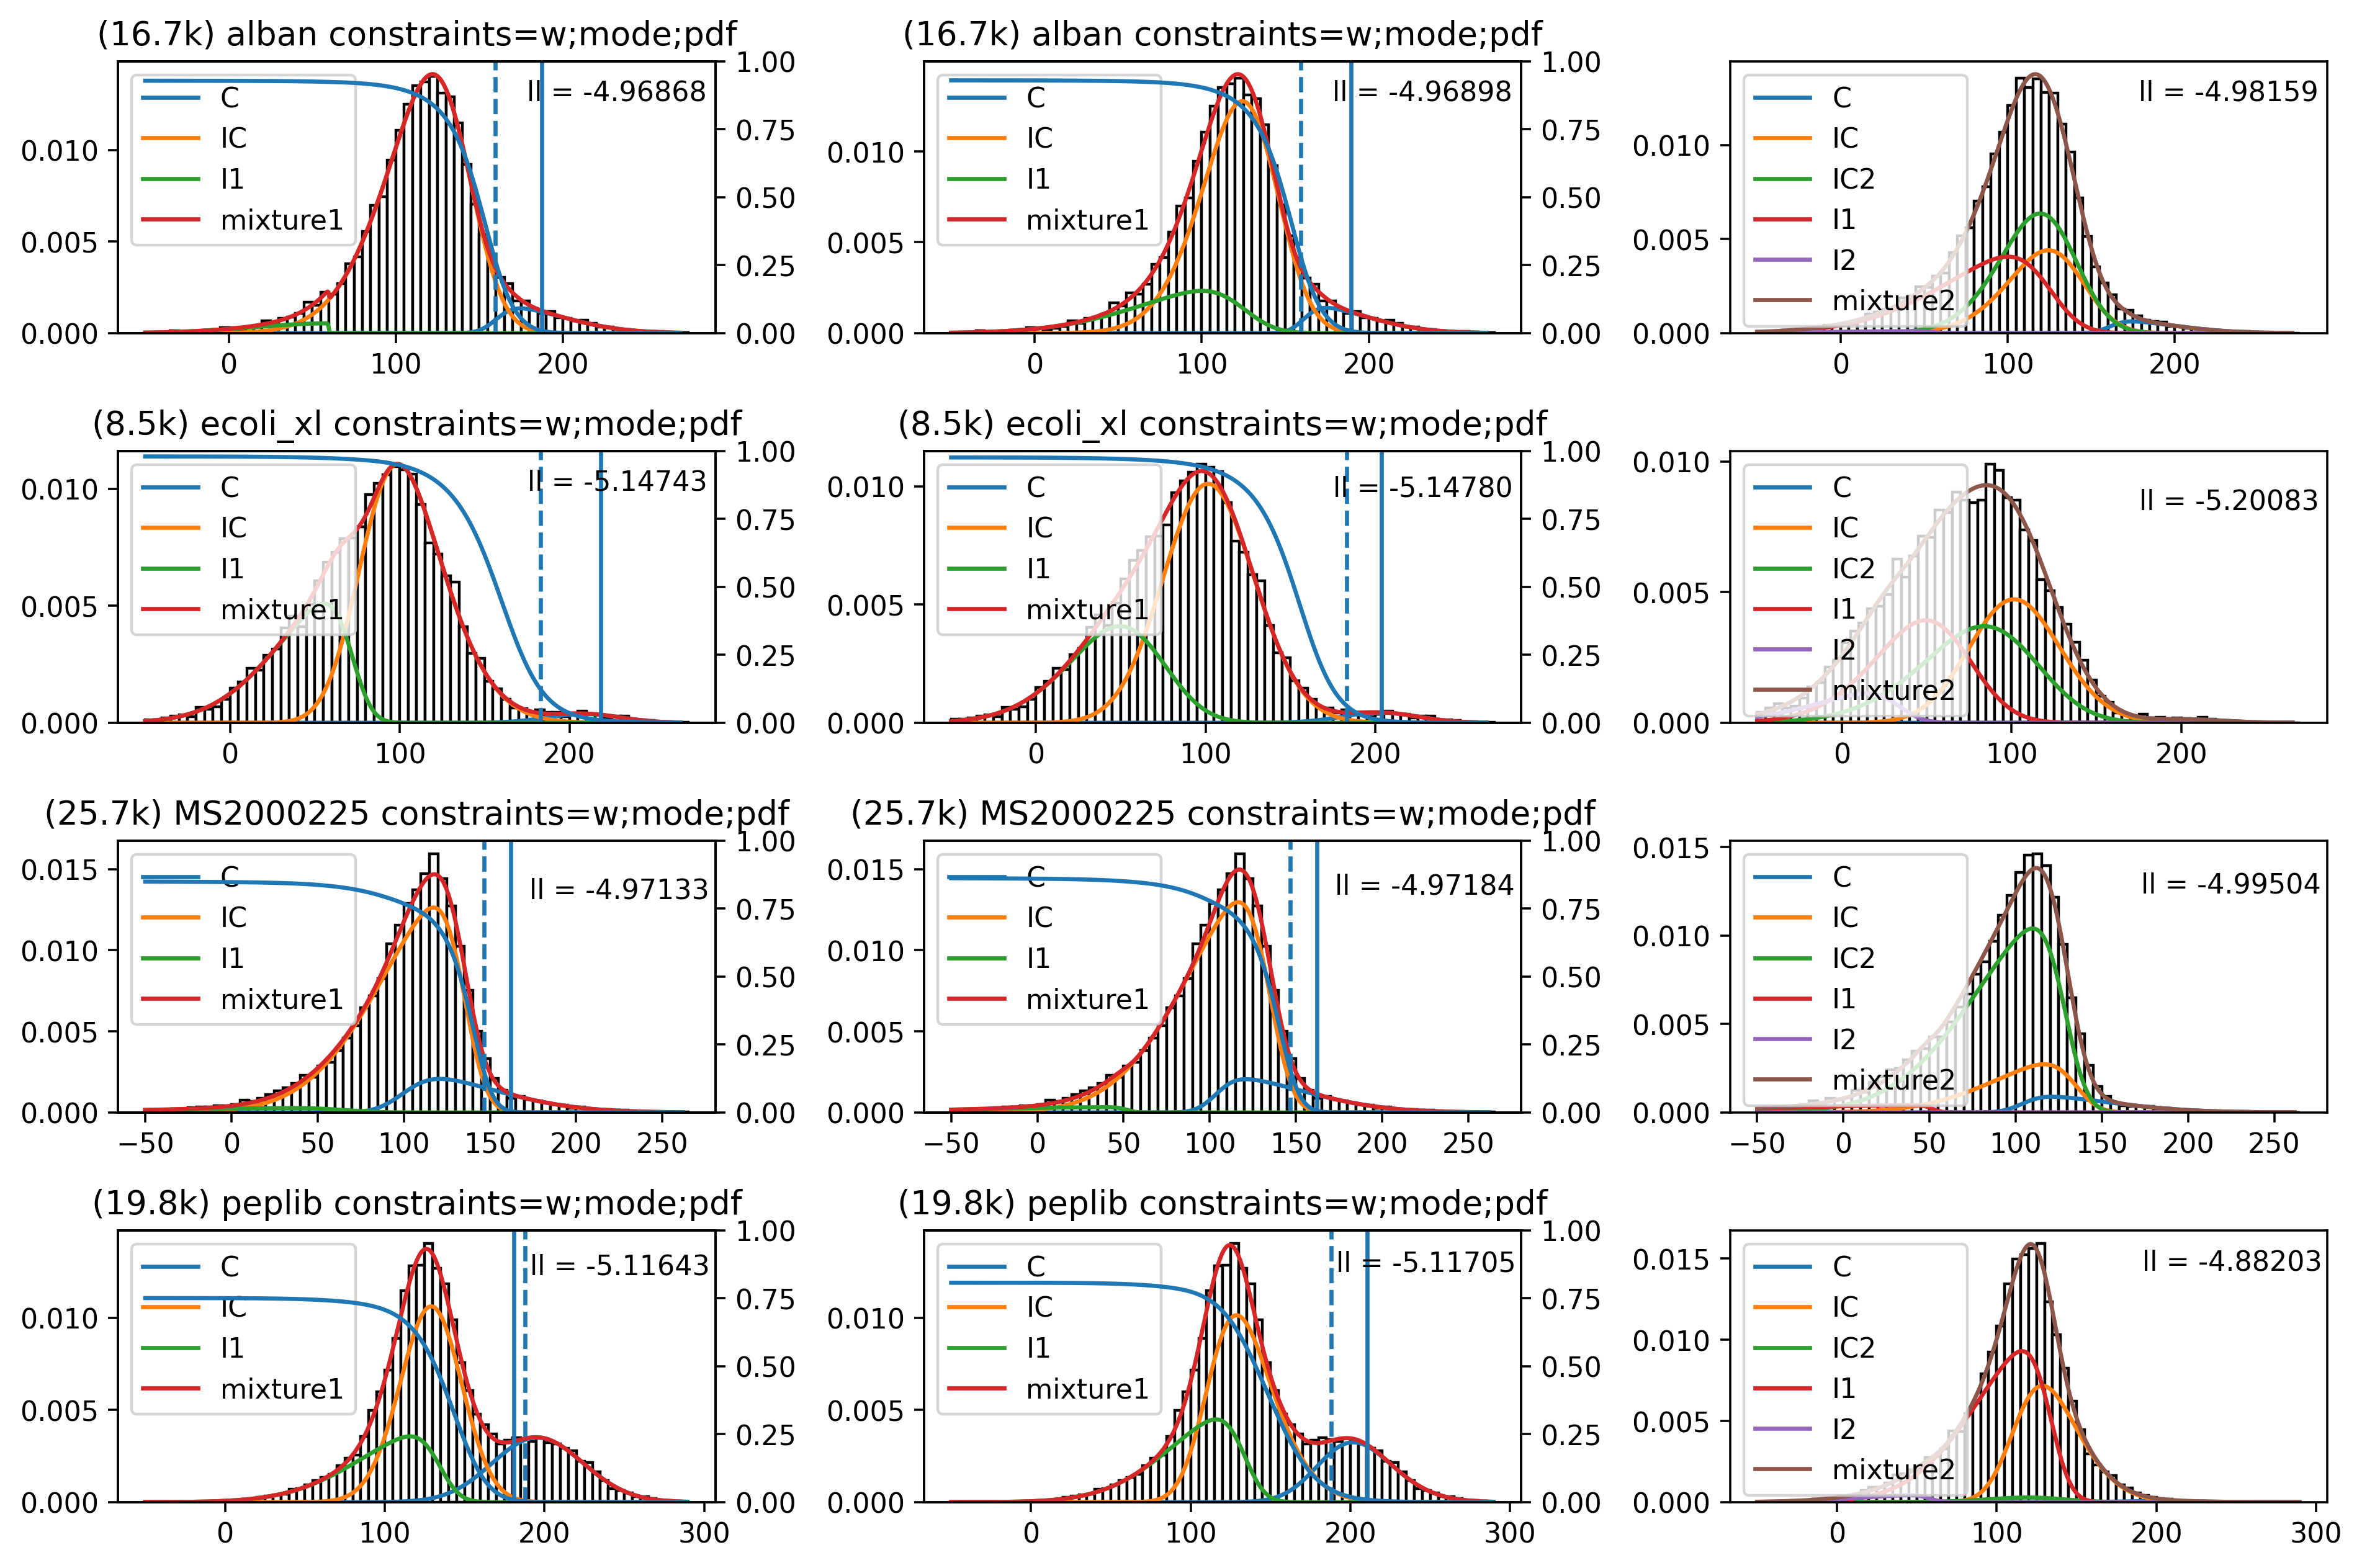

In [128]:
def plot_res(models_1s, models_2s):
    w = 12
    fig = plt.figure(figsize=(w, w/6 * N), dpi=320)
    fig.subplots(N, 3)
    i_ax = 0
    for i, dataset_name in enumerate(plot_datasets):
        ind = dataset_ind[dataset_name]

        dataset, tda_info = load_dataset(dataset_name)

        best_1s = reduce(model_ll_max, models_1s[ind], (0, 1))[()]
        best_2s = reduce(model_ll_max, models_2s[ind], (0, 1))[()]
        # print(best_1s.keys())
        plot_model_s1(best_1s, dataset, tda_info, fig.axes[i_ax])
        plot_model_s1(best_2s, dataset, tda_info, fig.axes[i_ax+1])
        plot_model_s2(best_2s, dataset, tda_info, fig.axes[i_ax+2])
        
        i_ax += 3
    
    fig.tight_layout()
        
plot_res(models_1s, models_2s)

In [25]:
models_1s[0, 0, 0].keys()

dict_keys(['ll', 'lls', 'sls', 'slls', 'model', 'cons_sat'])